In [1]:
import os
import json
from matplotlib import pyplot as plt

# Creating Vocab

In [2]:
descriptions = None

with open('descriptions.text','r') as f:
    descriptions = f.read()
    
descriptions = json.loads(descriptions.replace("'",'\"'))

print(type(descriptions))

<class 'dict'>


In [3]:
#Creating a set of all unique words

vocab = set()

for key in descriptions.keys():
    
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print('Number of unique words in the vocab is:',len(vocab))

    

Number of unique words in the vocab is: 8441


In [4]:
#Total number of words across the entire data

total_words = []

for key in descriptions.keys():
    [total_words.append(i) for sentence in descriptions[key] for i in sentence.split()]
    
print('Total number of words in the data is:',len(total_words))


Total number of words in the data is: 437466


In [5]:
import collections

#This gives the number of counts of all the words in the data

counter = collections.Counter(total_words)

frequency_cnt = dict(counter)

print(len(frequency_cnt.keys()))

8441


# Keeping only some frequently occuring words

In [6]:
#Sorting the dictionary

sorted_freq_cnt = sorted(frequency_cnt.items(),reverse=True,key=lambda x:x[1])

threshold = 10

sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]

total_words = [x[0] for x in sorted_freq_cnt]

print(len(total_words))

1850


# Preparing training and test data

In [7]:
with open('Flickr_8k.trainImages.txt','r') as f:
    train_file = f.read()
    
    
with open('Flickr_8k.testImages.txt','r') as f:
    test_file = f.read()

In [8]:
train = [row for row in train_file.split('\n')[:-1]]
print(train[:5])

['2513260012_03d33305cf.jpg', '2903617548_d3e38d7f88.jpg', '3338291921_fe7ae0c8f8.jpg', '488416045_1c6d903fe0.jpg', '2644326817_8f45080b87.jpg']


In [9]:
test = [row for row in test_file.split('\n')[:-1]]
print(test[:5])

['3385593926_d3e9c21170.jpg', '2677656448_6b7e7702af.jpg', '311146855_0b65fdb169.jpg', '1258913059_07c613f7ff.jpg', '241347760_d44c8d3a01.jpg']


In [10]:
#Adding a starting and an ending token to our captions so that the model will be able to understand when to end the sentence.

train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    
    for captions in descriptions[img_id]:
        start_seq = "<s> "
        end_seq = " <e>"
        to_add = start_seq + captions + end_seq
        train_descriptions[img_id].append(to_add)

In [11]:
train_descriptions['2513260012_03d33305cf.jpg']

['<s> a black dog is running after a white dog in the snow  <e>',
 '<s> black dog chasing brown dog through snow <e>',
 '<s> two dogs chase each other across the snowy ground  <e>',
 '<s> two dogs play together in the snow  <e>',
 '<s> two dogs running through a low lying body of water  <e>']

In [12]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM,add

In [13]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [14]:
model_new = Model(model.input,model.layers[-2].output)


In [15]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)     #Expanding dimensions of image
    
    img = preprocess_input(img)
    
    return img
    
    

Function for extracting feature vector

In [16]:
def encd_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    return feature_vector


In [17]:
c = encd_img('image/Images/1000268201_693b08cb0e.jpg')
c.shape

(2048,)

In [18]:
all_img_features = {}
img_path = 'image/Images/'

for i,img_id in enumerate(train):
    
    all_img_features[img_id] = encd_img(img_path+img_id)
    
    

In [19]:
#Store the features to disk
import pickle

with open('image_features.pkl','wb') as f:
    pickle.dump(all_img_features,f)

In [20]:
import pickle
with open('image_features.pkl','rb') as f:
    features = pickle.load(f)


In [21]:
#Creating feature vectors of test images

test_img_features = {}
img_path = 'image/Images/'

for i,img_id in enumerate(test):
    
    test_img_features[img_id] = encd_img(img_path+img_id)
    

In [22]:
with open('image_features_test.pkl','wb') as f:
    pickle.dump(test_img_features,f)

In [23]:
with open('image_features_test.pkl','rb') as f:
    test_features = pickle.load(f)


# Converting words to numeric values

In [24]:
len(total_words)

1850

In [25]:
total_words

['a',
 'in',
 'the',
 'on',
 'is',
 'and',
 'dog',
 'with',
 'man',
 'of',
 'two',
 'white',
 'black',
 'boy',
 'are',
 'woman',
 'girl',
 'to',
 'wearing',
 'at',
 'people',
 'water',
 'red',
 'young',
 'brown',
 'an',
 'his',
 'blue',
 'dogs',
 'running',
 'through',
 'playing',
 'while',
 'shirt',
 'down',
 'standing',
 'ball',
 'little',
 'grass',
 'snow',
 'child',
 'person',
 'jumping',
 'over',
 'three',
 'front',
 'sitting',
 'holding',
 'up',
 'field',
 'small',
 'by',
 'large',
 'green',
 'one',
 'group',
 'yellow',
 'her',
 'walking',
 'children',
 'men',
 'into',
 'air',
 'beach',
 'near',
 'mouth',
 'jumps',
 'another',
 'for',
 'street',
 'runs',
 'its',
 'from',
 'riding',
 'stands',
 'as',
 'bike',
 'girls',
 'outside',
 'other',
 'off',
 'out',
 'rock',
 'next',
 'play',
 'orange',
 'looking',
 'pink',
 'player',
 'camera',
 'their',
 'pool',
 'hat',
 'jacket',
 'boys',
 'women',
 'around',
 'behind',
 'some',
 'background',
 'dirt',
 'toy',
 'soccer',
 'sits',
 'dress

In [26]:
word_2_idx = {}
idx_2_word = {}

for i,word in enumerate(total_words):
    word_2_idx[word] = i+1
    idx_2_word[i+1] = word
    
print(len(word_2_idx))

1850


In [27]:
idx_2_word[3]

'the'

In [28]:
#Adding starting and end tokens to dictionary

word_2_idx["<s>"] = 1851
idx_2_word[1851] = "<s>"

word_2_idx["<e>"] = 1852
idx_2_word[1852] = "<e>"

vocab_size = len(word_2_idx)+1

print('Vocab size is:',vocab_size)

Vocab size is: 1853


In [29]:
import pickle
with open('word_2_idx','wb') as fw:
    pickle.dump(word_2_idx,fw)
    
with open('idx_2_word','wb') as fi:
    pickle.dump(idx_2_word,fi)    

In [30]:
#Defining maximum length of a sentence
max_len = 0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

38


In [31]:
def data_generator(train_descriptions,all_img_features,word_2_idx,max_len,batch_size):
    X1 = []
    X2 = []
    y = []
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = all_img_features[key]
            for desc in desc_list:
                
                seq = [word_2_idx[word] for word in desc.split() if word in word_2_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]            
                    yi = seq[i]              #Generating next word depending upon previous words in the sequence  
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]  #This is used to make all sentences of equal length.
                    yi = to_categorical([yi],num_classes=vocab_size)[0]                #This method creates a vector of y values of vocab size and puts a 1 on the index of y and 0 everywhere else 
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [np.array(X1),np.array(X2)] , np.array(y)
                    X1 = []
                    X2 = []
                    y = []
                    n = 0                    

In [32]:
f = open('glove.6B.50d.txt',encoding='utf-8')
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:],dtype = 'float')
    embedding_index[word] = coeff
f.close()

In [33]:
embedding_index['mango']     #The word 'mango' can be represented by a 50-dim vector

array([ 0.26381 , -0.31832 , -1.0953  ,  1.3305  ,  0.24761 ,  0.045313,
       -0.39509 , -0.52107 , -0.016796,  0.33175 , -0.53252 ,  0.43263 ,
        1.2306  , -0.36963 ,  0.15989 , -0.433   , -0.29768 ,  0.768   ,
        0.71255 , -0.85675 , -0.076953, -1.0284  ,  0.9337  ,  0.24969 ,
       -0.13985 ,  1.0316  , -0.15809 ,  0.80512 ,  0.50535 , -0.50557 ,
        1.1237  , -0.45083 , -0.27552 ,  1.3537  ,  0.3553  ,  0.39403 ,
       -1.1213  ,  0.027925,  0.57582 , -0.63611 , -0.53506 , -0.080186,
       -0.78026 , -1.1595  ,  1.0318  ,  0.94337 ,  0.026387, -0.96839 ,
        0.54497 , -0.16479 ])

In [34]:
#Converting every word vector into 50 dim-feature vector

def embd_matrix():
    embd_dim = 50
    vocab = vocab_size
    matrix = np.zeros((vocab,embd_dim))
    
    for word,idx in word_2_idx.items():
        embd_vector = embedding_index.get(word)
        
        if embd_vector is not None:
            matrix[idx] = embd_vector
        
    return matrix

In [35]:
embedding_matrix = embd_matrix()
print(embedding_matrix.shape)

(1853, 50)


In [36]:
embedding_matrix[1851]             #Since 1851 corresponds to'<s>' and it is not present in glove_embedding so it has all zeros

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Model Architecture

# LSTM

In [37]:
#Image Feature Model
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [38]:
#Parial Caption model
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)


In [39]:
#Combining both features.
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 50)       92650       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [40]:
#Embedding layer is pre_trained.
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [41]:
model.compile(optimizer="adam",loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [43]:
for i in range(20):
    generator = data_generator(train_descriptions,all_img_features,word_2_idx,max_len,batch_size)
    #history = model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    #model.save('models/model.weights'+str(i)+'.h5')
    

In [44]:
import keras
from matplotlib import pyplot as plt
model.compile(optimizer="adam",loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(generator,epochs=50,steps_per_epoch=steps,verbose=1)

Using TensorFlow backend.


Epoch 1/50
2000/2000 [==============================] - 11s 5ms/step - loss: 3.8789 - accuracy: 0.2833
Epoch 2/50
2000/2000 [==============================] - 9s 5ms/step - loss: 3.1927 - accuracy: 0.3416
Epoch 3/50
2000/2000 [==============================] - 9s 5ms/step - loss: 2.9600 - accuracy: 0.3635
Epoch 4/50
2000/2000 [==============================] - 9s 5ms/step - loss: 2.8204 - accuracy: 0.3767
Epoch 5/50
2000/2000 [==============================] - 9s 5ms/step - loss: 2.7182 - accuracy: 0.3879
Epoch 6/50
2000/2000 [==============================] - 9s 5ms/step - loss: 2.6450 - accuracy: 0.3946
Epoch 7/50
2000/2000 [==============================] - 9s 5ms/step - loss: 2.5860 - accuracy: 0.3998
Epoch 8/50
2000/2000 [==============================] - 9s 5ms/step - loss: 2.5354 - accuracy: 0.4056
Epoch 9/50
2000/2000 [==============================] - 9s 5ms/step - loss: 2.4957 - accuracy: 0.4098
Epoch 10/50
2000/2000 [==============================] - 9s 5ms/step - loss: 2.46

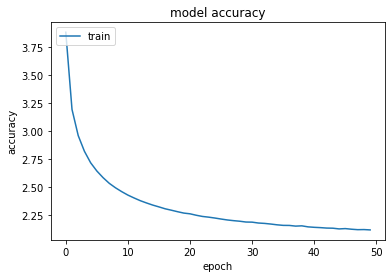

In [45]:
#plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

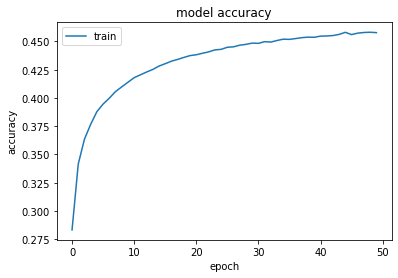

In [46]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
acc = history.history['accuracy']
lstm_acc = acc[49]
lstm_acc

0.4577418267726898

# CNN

In [49]:
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
input1 = Input(shape=(2048,))
input2 = Input(shape=(8441,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [50]:
caption_model.compile(optimizer="adam",loss='categorical_crossentropy', metrics=['accuracy'])
history1 = caption_model.fit(generator,epochs=50,steps_per_epoch=steps,verbose=1)

Epoch 1/50
2000/2000 [==============================] - 15s 7ms/step - loss: 5.0636 - accuracy: 0.1336
Epoch 2/50
2000/2000 [==============================] - 14s 7ms/step - loss: 4.8490 - accuracy: 0.1359
Epoch 3/50
2000/2000 [==============================] - 14s 7ms/step - loss: 4.7764 - accuracy: 0.1361
Epoch 4/50
2000/2000 [==============================] - 14s 7ms/step - loss: 4.7234 - accuracy: 0.1358
Epoch 5/50
2000/2000 [==============================] - 14s 7ms/step - loss: 4.6893 - accuracy: 0.1357
Epoch 6/50
2000/2000 [==============================] - 14s 7ms/step - loss: 4.6658 - accuracy: 0.1360
Epoch 7/50
2000/2000 [==============================] - 14s 7ms/step - loss: 4.6427 - accuracy: 0.1356
Epoch 8/50
2000/2000 [==============================] - 14s 7ms/step - loss: 4.6293 - accuracy: 0.1359
Epoch 9/50
2000/2000 [==============================] - 14s 7ms/step - loss: 4.6130 - accuracy: 0.1359
Epoch 10/50
2000/2000 [==============================] - 14s 7ms/step - l

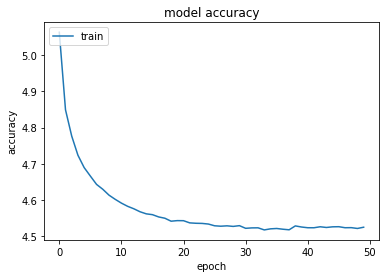

In [51]:
#plt.plot(history.history['accuracy'])
plt.plot(history1.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

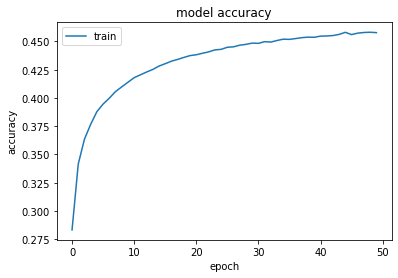

In [52]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [53]:
acc = history1.history['accuracy']
cnn_acc = acc[49]
cnn_acc

0.13565297424793243

# VGG16

In [54]:
from tensorflow.keras.applications.vgg16 import VGG16
model3 = VGG16(weights='imagenet',input_shape=(224,224,3))

553467904/553467096 [==============================] - 29s 0us/step


In [55]:
# Combined Model
model3 = Model(inputs=[input_img_features,input_captions],outputs=outputs)

model3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 50)       92650       input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [56]:
import keras
from matplotlib import pyplot as plt
model3.compile(optimizer="adam",loss='categorical_crossentropy', metrics=['accuracy'])
history3 = model3.fit(generator,epochs=50,steps_per_epoch=steps,verbose=1)

Epoch 1/50
2000/2000 [==============================] - 11s 5ms/step - loss: 2.1532 - accuracy: 0.4542
Epoch 2/50
2000/2000 [==============================] - 9s 5ms/step - loss: 2.1299 - accuracy: 0.4579
Epoch 3/50
2000/2000 [==============================] - 9s 5ms/step - loss: 2.1258 - accuracy: 0.4573
Epoch 4/50
2000/2000 [==============================] - 9s 5ms/step - loss: 2.1232 - accuracy: 0.4576
Epoch 5/50
2000/2000 [==============================] - 9s 4ms/step - loss: 2.1160 - accuracy: 0.4580
Epoch 6/50
2000/2000 [==============================] - 9s 4ms/step - loss: 2.1125 - accuracy: 0.4585
Epoch 7/50
2000/2000 [==============================] - 9s 4ms/step - loss: 2.1155 - accuracy: 0.4588
Epoch 8/50
2000/2000 [==============================] - 9s 4ms/step - loss: 2.1121 - accuracy: 0.4590
Epoch 9/50
2000/2000 [==============================] - 9s 4ms/step - loss: 2.1097 - accuracy: 0.4600
Epoch 10/50
2000/2000 [==============================] - 9s 4ms/step - loss: 2.10

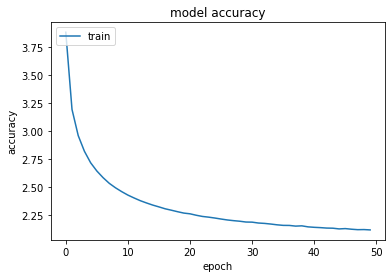

In [57]:
#plt.plot(history2.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

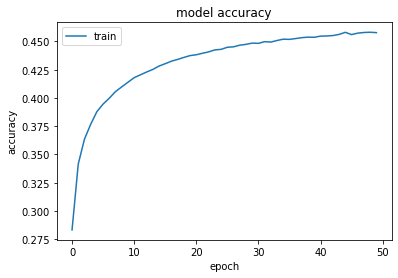

In [59]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
acc = history3.history['accuracy']
vgg_acc = acc[49]
vgg_acc

0.4681141674518585

# Accuracy Comparison

In [61]:
score = [lstm_acc,cnn_acc,vgg_acc]

In [62]:
#make variabel for save the result and to show it
classifier = ('LSTM','CNN','VGG16')
y_pos = np.arange(len(classifier))
print(y_pos)
print(score)

[0 1 2]
[0.4577418267726898, 0.13565297424793243, 0.4681141674518585]


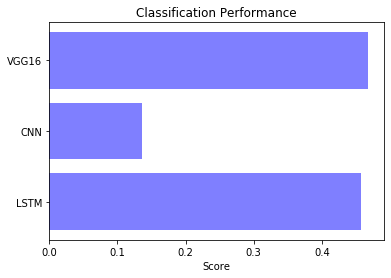

In [63]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, score, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Score')
plt2.title('Classification Performance')
plt2.show()